<a href="https://colab.research.google.com/github/yuhui-0611/ESAA/blob/main/ESAA_YB_mini_project3_%EC%84%A0%ED%98%95%ED%9A%8C%EA%B7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

미니 프로젝트 (3)

# 영화 관객 수 예측 경진대회
- 회귀 알고리즘을 이용하여 예측하기

### 1. 전처리

In [47]:
# 한글 폰트 설정
# 나눔 바른 고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib
import matplotlib.pyplot as plt # Add this line
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
print("한글 폰트 설정 완료")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # Add this line
plt.rc('font', family='NanumBarunGothic')  # matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/movies_train.csv')
train.head(5)

In [ ]:
train.info()

In [ ]:
train.describe()

### 결측치 확인

In [ ]:
train.isna().sum()

### 이전 영화 박스오피스 수 (dir_prev_num)의 na 값 0으로 채움

In [ ]:
train.dir_prev_bfnum.fillna(0, inplace=True)

### release_time 을 날짜로 인식하도록 변경하고 년, 월, 일 구별하는 피처 생성

In [ ]:
train['release_time'] = pd.to_datetime(train['release_time'])
train['year'] = train['release_time'].dt.year
train['month'] = train['release_time'].dt.month
train['weekday'] = train['release_time'].dt.day_of_week
# 0~6 : 월요일~일요일

train.head(5)

### 상관관계가 높거나 불필요한 피처 제거

In [ ]:
corr = train.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
# 상관계수 행렬
corr_matrix = train.corr(numeric_only=True).abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 기준 이상이면 제거 리스트에 추가
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

print("제거 후보:", to_drop)

- 상관계수가 0.6 이상인 변수 num_staff 하나뿐 -> 선택해서 드랍해도 되고 안해도 될듯

In [ ]:
numeric_cols = train.select_dtypes(include=['number'])
numeric_cols.corr()['num_staff'].sort_values(ascending=False)

- 피처별 분포 모양을 보고 로그변환 해주기

In [ ]:
cols = ['time', 'dir_prev_bfnum', 'num_staff', 'num_actor', 'box_off_num']

plt.figure(figsize=(12, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(train[col], kde=True)
    plt.title(f"{col} (skew={train[col].skew():.2f})")

plt.tight_layout()
plt.show()

In [ ]:
cols_to_transform = ['dir_prev_bfnum', 'num_staff', 'num_actor', 'box_off_num']

# 변환 전후 분포 비교
for col in cols_to_transform:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(train[col], ax=ax[0], kde=True)
    ax[0].set_title(f"{col} - Before")

    # log1p 변환 (log(x+1))
    train[col + "_log"] = np.log1p(train[col])

    sns.histplot(train[col + "_log"], ax=ax[1], kde=True)
    ax[1].set_title(f"{col} - After (log1p)")

    plt.show()


- 분포가 안정적으로 바뀐 box_off_num_log, num_actor_log 피처는 로그변환하면 좋을듯
- 나머지 dir_prev_bfnum, num_staff 는 로그변환해도 치우친 모습 -> 선택하면 될듯

**< 겹치거나 무의미한 컬럼들 삭제 >**

-  title
- director
- release_time
> 이미 year, month, weekday로 분리했으니까 중복됨

- box_off_num
> 이미 타깃을 box_off_num_log 로 사용하니까 제거

- num_actor
- num_staff
- dir_prev_bfnum
> 로그변환한 것을 사용하기 위해 원래 컬럼 제거

In [ ]:
cols_to_drop = [
    'title', 'director', 'release_time', 'distributor', 'box_off_num',
    'num_actor', 'num_staff', 'dir_prev_bfnum'
]

train = train.drop(columns=cols_to_drop)

In [ ]:
corr = train.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
# 상관관계가 높은 것 제거
train = train.drop(columns=['dir_prev_num'])

In [ ]:
train.head()

In [ ]:
cols_to_ohe = ['genre', 'screening_rat', 'year', 'month', 'weekday']

train = pd.get_dummies(train, columns=cols_to_ohe)

In [ ]:
train.head()

In [ ]:
sns.pairplot(train[['num_staff_log', 'num_actor_log', 'dir_prev_bfnum_log', 'box_off_num_log']])
plt.show()

- dir_prev_bfnum_log 의 경우 0인값이 매우많음(신인감독)

- 신인 여부를 새로 칼럼으로 추가

In [ ]:
train['is_rookie_director'] = (train['dir_prev_bfnum_log'] == 0).astype(int)

# **최종 전처리 코드 정리**

1. train

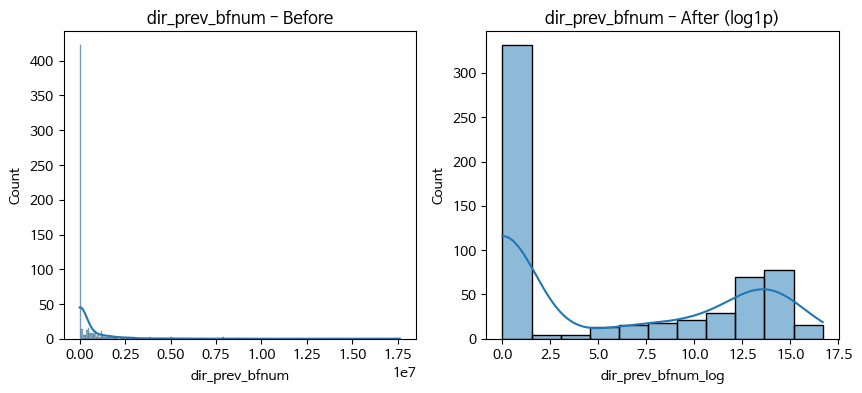

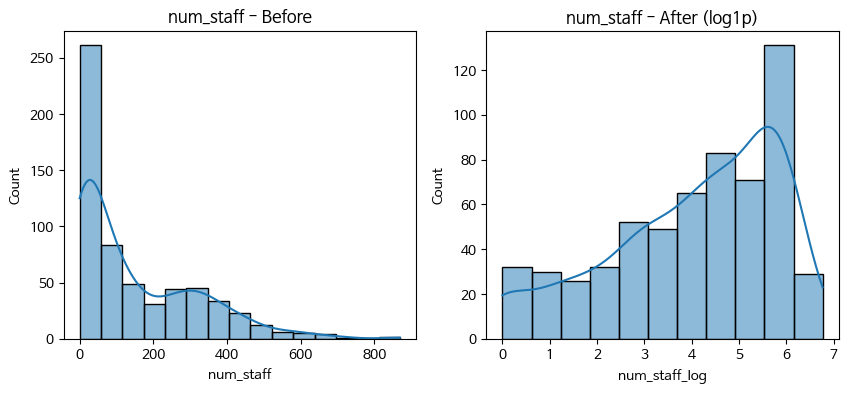

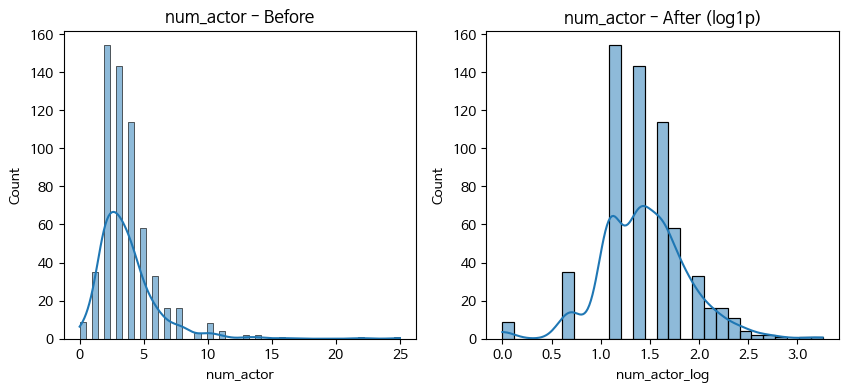

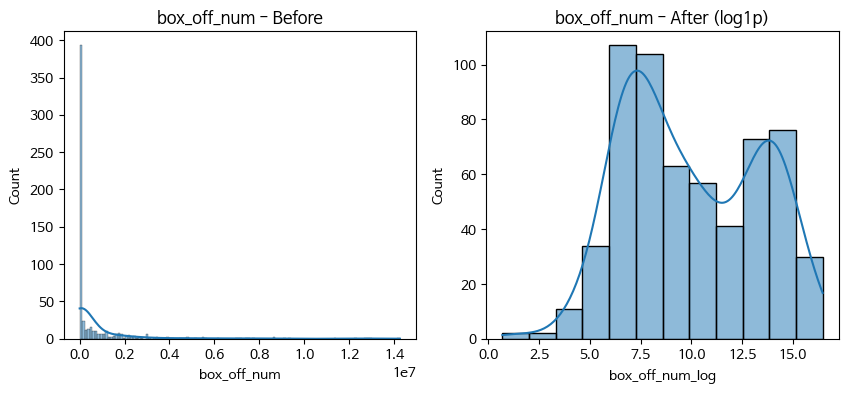

   time  dir_prev_bfnum_log  num_staff_log  num_actor_log  box_off_num_log  \
0    96            0.000000       4.521789       1.098612        10.060449   
1   130           13.965312       5.961005       1.386294        15.771725   
2   123           12.304905       5.840642       1.609438        15.755558   
3   101           10.081425       3.044522       1.945910        12.291640   
4   108            0.693147       5.529429       1.098612        13.088575   

   is_rookie_director  genre_SF  genre_공포  genre_느와르  genre_다큐멘터리  ...  \
0                   1     False     False      False        False  ...   
1                   0     False     False       True        False  ...   
2                   0     False     False      False        False  ...   
3                   0     False     False      False        False  ...   
4                   0     False     False      False        False  ...   

   month_9  month_10  month_11  month_12  weekday_0  weekday_1  weekday_2  \
0    Fals

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('/content/drive/MyDrive/ESAA/movies_train.csv')

# 결측치 처리
train['dir_prev_bfnum'].fillna(0, inplace=True)

# 날짜 처리
train['release_time'] = pd.to_datetime(train['release_time'])
train['year'] = train['release_time'].dt.year
train['month'] = train['release_time'].dt.month
train['weekday'] = train['release_time'].dt.day_of_week

# 로그 변환
cols_to_transform = ['dir_prev_bfnum', 'num_staff', 'num_actor', 'box_off_num']

for col in cols_to_transform:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(train[col], ax=ax[0], kde=True)
    ax[0].set_title(f"{col} - Before")

    train[col + "_log"] = np.log1p(train[col])

    sns.histplot(train[col + "_log"], ax=ax[1], kde=True)
    ax[1].set_title(f"{col} - After (log1p)")

    plt.show()

# 신인 감독 여부 파생 변수
train['is_rookie_director'] = (train['dir_prev_bfnum_log'] == 0).astype(int)

# 제거할 원본 변수들
cols_to_drop = [
    'title', 'director', 'release_time', 'distributor', 'box_off_num',
    'num_actor', 'num_staff', 'dir_prev_bfnum',
]

train = train.drop(columns=cols_to_drop)

train = train.drop(columns=['dir_prev_num'])

# One-Hot Encoding
cols_to_ohe = ['genre', 'screening_rat', 'year', 'month', 'weekday']
train = pd.get_dummies(train, columns=cols_to_ohe)

# 결과 확인
print(train.head())
print("train shape:", train.shape)


2. test

train과 똑같이 적용

In [4]:
test = pd.read_csv('/content/drive/MyDrive/ESAA/movies_test.csv')

test['dir_prev_bfnum'].fillna(0, inplace=True)

test['release_time'] = pd.to_datetime(test['release_time'])
test['year'] = test['release_time'].dt.year
test['month'] = test['release_time'].dt.month
test['weekday'] = test['release_time'].dt.day_of_week

cols_to_transform = ['dir_prev_bfnum', 'num_staff', 'num_actor']

for col in cols_to_transform:
    test[col + "_log"] = np.log1p(test[col])

test['is_rookie_director'] = (test['dir_prev_bfnum_log'] == 0).astype(int)

cols_to_drop = [
    'title', 'director', 'release_time', 'distributor',
    'num_actor', 'num_staff', 'dir_prev_bfnum',
]

test = test.drop(columns=cols_to_drop)

test = test.drop(columns=['dir_prev_num'])

cols_to_ohe = ['genre', 'screening_rat', 'year', 'month', 'weekday']
test = pd.get_dummies(test, columns=cols_to_ohe)

3. 데이터 분리

In [5]:
y = train['box_off_num_log']
X = train.drop(columns=['box_off_num_log'])

test_df = test.copy()

X_test = test_df.reindex(columns=X.columns, fill_value=0)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

X shape: (600, 45)
y shape: (600,)
X_test shape: (243, 45)


- One-hot encoding을 하면 train과 test의 컬럼 구성이 달라지기 때문에, 모델이 학습한 컬럼 구조와 test의 컬럼을 완전히 동일하게 맞추기 위해 reindex()를 사용
- 예측 후에는 y를 원래 scale로 복구해야 함

# 선형 회귀

- 각 모델을 돌린 다음, 동일한 평가 지표로 비교하여 가장 숫자가 좋은 모델 채택
> RMSE : 오차의 평균적인 크기

In [6]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

In [7]:
### alpha 값 변화에 따른 결과 출력 함수 for Ridge & Lasso & ElasticNet ###

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose: print('######', model_name, '######')
  for param in params:
    if model_name == 'Ridge': model = Ridge(alpha=param)
    elif model_name == 'Lasso': model = Lasso(alpha=param)
    elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n,
                                     y_target_n, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    model.fit(X_data_n, y_target_n)
    if return_coeff:
      # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff

  return coeff_df
# end of get_linear_regre_eval

## 릿지 회귀

In [8]:
ridge_alphas = [0.07, 0.1, 1, 10, 100]
coeff_lasso_df = get_linear_reg_eval('Ridge', params=ridge_alphas, X_data_n = X, y_target_n = y)

###### Ridge ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 2.196
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 2.195
alpha 1일 때 5 폴드 세트의 평균 RMSE: 2.172
alpha 10일 때 5 폴드 세트의 평균 RMSE: 2.136
alpha 100일 때 5 폴드 세트의 평균 RMSE: 2.164


- alpha = 10일 때가 가장 good

## 라쏘 회귀

In [9]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n = X, y_target_n = y)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 2.164
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 2.181
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 2.362
alpha 1일 때 5 폴드 세트의 평균 RMSE: 2.429
alpha 3일 때 5 폴드 세트의 평균 RMSE: 2.568


- alpha = 0.07일 때가 가장 good

## 엘라스틱넷 회귀

In [10]:
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X, y_target_n = y)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 2.156
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 2.174
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 2.355
alpha 1일 때 5 폴드 세트의 평균 RMSE: 2.396
alpha 3일 때 5 폴드 세트의 평균 RMSE: 2.548


- alpha = 0.07일 때가 가장 good

### 선형 계열 회귀 결론

< Ridge >
- alpha 10일 때 5 폴드 세트의 평균 RMSE: 2.136

< Lasso >
- alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 2.164

< ElasticNet >
- alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 2.156

> 즉, Ridge 회귀로 돌렸을 때의 RMSE가 가장 낮기에 해당 모델 선택

In [11]:
ridge_reg = Ridge(alpha=10, random_state=42)
ridge_reg.fit(X, y)

# test 데이터 예측 (로그 스케일 → 원래 스케일)
ridge_pred_log = ridge_reg.predict(X_test)    # log1p(box_off_num) 예측
ridge_pred = np.expm1(ridge_pred_log)          # expm1으로 원래 관객 수 복구

In [12]:
ridge_pred

array([5.83210640e+05, 2.88448369e+05, 3.12033376e+05, 4.25007546e+05,
       3.26995167e+05, 7.94433517e+03, 3.34780860e+03, 2.56054988e+03,
       5.51643091e+03, 6.99842932e+04, 1.66155480e+05, 2.49258390e+05,
       2.94841469e+04, 3.84818373e+03, 2.08807018e+05, 4.34291693e+06,
       1.15877273e+04, 1.55695512e+05, 1.49880461e+04, 2.19648477e+03,
       4.61872862e+02, 2.18383363e+04, 2.43837174e+05, 6.34131196e+03,
       1.73151645e+03, 3.52907342e+05, 5.44517350e+02, 9.62990841e+04,
       1.74048482e+04, 3.54368451e+04, 1.40769842e+05, 1.18497995e+03,
       4.57374097e+03, 3.21605789e+06, 1.36750909e+04, 4.57164191e+03,
       7.12761948e+03, 3.26665518e+03, 8.34637522e+03, 7.36787563e+02,
       5.75763419e+04, 2.13593541e+04, 1.87744163e+04, 3.43585048e+05,
       6.19924896e+04, 2.55519903e+05, 6.03015705e+03, 5.01625033e+04,
       7.61396489e+04, 6.97205943e+03, 7.58626836e+03, 3.43128338e+05,
       2.53731570e+04, 1.99042397e+06, 6.96085777e+04, 3.27745662e+04,
      

In [13]:
print(ridge_pred.min(), ridge_pred.max())
print(ridge_pred.mean())

41.00636067202371 3.0969747605268713e+50
1.2744752100933626e+48


- pred 값이 매우 이상함
- 이상치 확인해봐야할 듯

In [14]:
print("ridge_pred_log  min/max/mean:",
      ridge_pred_log.min(), ridge_pred_log.max(), ridge_pred_log.mean())

print("ridge_pred      min/max/mean:",
      ridge_pred.min(), ridge_pred.max(), ridge_pred.mean())

ridge_pred_log  min/max/mean: 3.73782105138879 116.25968040100786 10.554157698612414
ridge_pred      min/max/mean: 41.00636067202371 3.0969747605268713e+50 1.2744752100933626e+48


In [16]:
import numpy as np

pred = ridge_pred_log  # 로그 예측값 기준

Q1 = np.percentile(pred, 25)
Q3 = np.percentile(pred, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print("IQR lower:", lower)
print("IQR upper:", upper)

outlier_index_pred = np.where((pred < lower) | (pred > upper))[0]
print("예측 이상치 개수:", len(outlier_index_pred))
print(outlier_index_pred[:20])

IQR lower: 2.2638221430080376
IQR upper: 18.21107507987924
예측 이상치 개수: 1
[224]


In [17]:
row = X_test.iloc[224]
row_x = X.iloc[224]

In [19]:
import pandas as pd

coef = ridge_reg.coef_

contrib_df = pd.DataFrame({
    "feature": X_test.columns,
    "value": row.values,
    "coef": coef,
    "contribution": row.values * coef
})

contrib_df.sort_values("contribution", ascending=False).head(10)


,feature,value,coef,contribution
0,time,2015,0.055480,111.793036
14,genre_애니메이션,True,1.237834,1.237834
2,num_staff_log,1.609438,0.762413,1.227057
19,screening_rat_전체 관람가,True,0.645115,0.645115
35,month_9,True,0.339483,0.339483
4,is_rookie_director,1,0.308510,0.30851
3,num_actor_log,1.791759,0.074618,0.133697
33,month_7,False,0.163490,0.0
27,month_1,False,0.262329,0.0
28,month_2,False,-0.061482,-0.0


In [20]:
train['time'].describe()
print("train time max:", train['time'].max())
print("test time max:", test['time'].max())

train time max: 180
test time max: 2015


In [22]:
test[test['time'] == 2015]

,time,dir_prev_bfnum_log,num_staff_log,num_actor_log,is_rookie_director,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,...,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_6
224,2015,0.0,1.609438,1.791759,1,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [24]:
# time == 2015인 행 하나 뽑기
row = test[test['time'] == 2015].iloc[0]

# genre_ 로 시작하는 컬럼만 골라서
genre_cols = [c for c in test.columns if c.startswith('genre_')]

# 그 중 값이 1(True)인 컬럼만 뽑기
genre_list = [c.replace('genre_', '') for c in genre_cols if row[c] == 1 or row[c] == True]

print("이 영화 장르:", genre_list)

이 영화 장르: ['애니메이션']


In [25]:
# 애니메이션 영화만 골라서 상영시간 평균 구하기
ani_mean_time = train.loc[train['genre_애니메이션'] == 1, 'time'].mean()
print("애니메이션 평균 상영시간:", ani_mean_time)

애니메이션 평균 상영시간: 82.57142857142857


In [26]:
ani_mean_time = round(ani_mean_time)

In [27]:
# 조건: 애니메이션이면서 time이 2015인 행
cond = (test['genre_애니메이션'] == 1) & (test['time'] == 2015)

# 그 행들의 time 값을 애니메이션 평균 상영시간으로 대체
test.loc[cond, 'time'] = ani_mean_time

### Ridge 결론

- 이제 다시 Ridge

In [31]:
test_df = test.copy()
X_test = test_df.reindex(columns=X.columns, fill_value=0)

In [32]:
ridge_reg = Ridge(alpha=10, random_state=42)
ridge_reg.fit(X, y)

# test 데이터 예측 (로그 스케일 → 원래 스케일)
ridge_pred_log = ridge_reg.predict(X_test)    # log1p(box_off_num) 예측
ridge_pred = np.expm1(ridge_pred_log)          # expm1으로 원래 관객 수 복구

In [33]:
ridge_pred

array([5.83210640e+05, 2.88448369e+05, 3.12033376e+05, 4.25007546e+05,
       3.26995167e+05, 7.94433517e+03, 3.34780860e+03, 2.56054988e+03,
       5.51643091e+03, 6.99842932e+04, 1.66155480e+05, 2.49258390e+05,
       2.94841469e+04, 3.84818373e+03, 2.08807018e+05, 4.34291693e+06,
       1.15877273e+04, 1.55695512e+05, 1.49880461e+04, 2.19648477e+03,
       4.61872862e+02, 2.18383363e+04, 2.43837174e+05, 6.34131196e+03,
       1.73151645e+03, 3.52907342e+05, 5.44517350e+02, 9.62990841e+04,
       1.74048482e+04, 3.54368451e+04, 1.40769842e+05, 1.18497995e+03,
       4.57374097e+03, 3.21605789e+06, 1.36750909e+04, 4.57164191e+03,
       7.12761948e+03, 3.26665518e+03, 8.34637522e+03, 7.36787563e+02,
       5.75763419e+04, 2.13593541e+04, 1.87744163e+04, 3.43585048e+05,
       6.19924896e+04, 2.55519903e+05, 6.03015705e+03, 5.01625033e+04,
       7.61396489e+04, 6.97205943e+03, 7.58626836e+03, 3.43128338e+05,
       2.53731570e+04, 1.99042397e+06, 6.96085777e+04, 3.27745662e+04,
      

In [34]:
print(ridge_pred.min(), ridge_pred.max())
print(ridge_pred.mean())

41.00636067202371 8530519.382029619
380364.3283854968


# 회귀트리

In [35]:
from sklearn.model_selection import train_test_split

y_target = train['box_off_num_log']
X_features = train.drop(columns=['box_off_num_log'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

In [36]:
from sklearn.model_selection import cross_val_score

def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('##### ',model.__class__.__name__,' #####')
  print('5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

In [37]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model,params):
  grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_train, y_train)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                           np.round(rmse,4), grid_model.best_params_))

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

## XGB

In [39]:
get_model_cv_prediction(xgb_reg, X_train, y_train)

#####  XGBRegressor  #####
5 교차 검증의 평균 RMSE:2.049


In [40]:
# XGB에 맞는 하이퍼 파라미터 설정
param_grid = {
    'n_estimators':[100,200,300,500,1000],
    'learning_rate':[0.05,0.1,0.15],
    'max_depth':[3,5,7],
    'colsample_bytree':[0.5,0.7,0.9],
    'subsample':[0.5,0.7,0.9]
}

# 이전에 정의된 xgb_reg 모델 사용
grid_search = GridSearchCV(xgb_reg, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, refit=True)

In [41]:
grid_search.fit(X_train, y_train)
print_best_params(xgb_reg, param_grid)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:1.874, 최적 alpha:{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}


In [42]:
# XGB에 맞는 하이퍼 파라미터 설정
param_grid = {
    'n_estimators':[100],
    'learning_rate':[0.05],
    'max_depth':[3],
    'colsample_bytree':[0.9],
    'subsample':[0.5],
    'reg_alpha':[0, 0.01, 0.1, 1],
    'reg_lambda':[0, 0.01, 0.1, 1]
}

In [43]:
grid_search.fit(X_train, y_train)
print_best_params(xgb_reg, param_grid)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:1.874, 최적 alpha:{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.5}


# 혼합

- ridge_pred & xgb_pred
    - alpha = 10
    - n_estimators=1000, learning_rate=0.05, colsample_bytree=0.9, subsample=0.5, max_depth=3

In [44]:
from sklearn.metrics import mean_squared_error

def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE： {1}'.format(key, rmse))

In [45]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.9,
                       subsample=0.5, max_depth=3)
xgb_reg.fit(X_train, y_train)
xgb_valid_pred = xgb_reg.predict(X_test)

In [46]:
ridge_reg = Ridge(alpha=10, random_state=42)
ridge_reg.fit(X_train, y_train)
ridge_valid_pred = ridge_reg.predict(X_test)

In [48]:
preds = {
    "XGB": xgb_valid_pred,
    "Ridge": ridge_valid_pred,
    "Blend_06_04": 0.6 * xgb_valid_pred + 0.4 * ridge_valid_pred,
    "Blend_05_05": 0.5 * xgb_valid_pred + 0.5 * ridge_valid_pred,
    "Blend_07_03": 0.7 * xgb_valid_pred + 0.3 * ridge_valid_pred,
    "Blend_08_02": 0.8 * xgb_valid_pred + 0.2 * ridge_valid_pred
}

get_rmse_pred(preds)

XGB 모델의 RMSE： 2.102520032379778
Ridge 모델의 RMSE： 2.3022030015690205
Blend_06_04 모델의 RMSE： 2.05206875306543
Blend_05_05 모델의 RMSE： 2.06773986637792
Blend_07_03 모델의 RMSE： 2.047732661381045
Blend_08_02 모델의 RMSE： 2.0548035597454994


- xbg 0.7 & ridge 0.3 성능이 가장 good